In [2]:

def calculate_rolling_spread(
        df0: pd.DataFrame,          # 必含 'date' 与价格列
        df1: pd.DataFrame,
        window: int = 30,
        fields=('open', 'high', 'low', 'close')
    ) -> pd.DataFrame:
    """
    计算滚动 β，并为指定价格字段生成价差 (spread)：
        spread_x = price0_x - β_{t-1} * price1_x
    """
    # 1) 用收盘价对齐合并（β 仍用 close 估计）
    df = (df0.set_index('date')[['close']]
              .rename(columns={'close': 'close0'})
              .join(df1.set_index('date')[['close']]
                        .rename(columns={'close': 'close1'}),
                    how='inner'))

    # 2) 估计 β_t ，再向前挪一天
    beta_raw   = df['close0'].rolling(window).cov(df['close1']) / \
                 df['close1'].rolling(window).var()
    beta_shift = beta_raw.shift(1).round(1)        # 防未来 + 保留 1 位小数

    # 3) 把 β 拼回主表（便于后面 vectorized 计算）
    df = df.assign(beta=beta_shift)

    # 4) 对每个字段算 spread
    out_cols = {'date': df.index, 'beta': beta_shift}
    for f in fields:
        if f not in ('open','high','low','close'):
            raise ValueError(f'未知字段 {f}')
        p0 = df0.set_index('date')[f]
        p1 = df1.set_index('date')[f]
        aligned = p0.to_frame(name=f'price0_{f}').join(
                  p1.to_frame(name=f'price1_{f}'), how='inner')
        spread_f = aligned[f'price0_{f}'] - beta_shift * aligned[f'price1_{f}']
        out_cols[f'{f}'] = spread_f

    # 5) 整理输出
    out = (pd.DataFrame(out_cols)
             .dropna()
             .reset_index(drop=True))
    out['date'] = pd.to_datetime(out['date'])
    return out


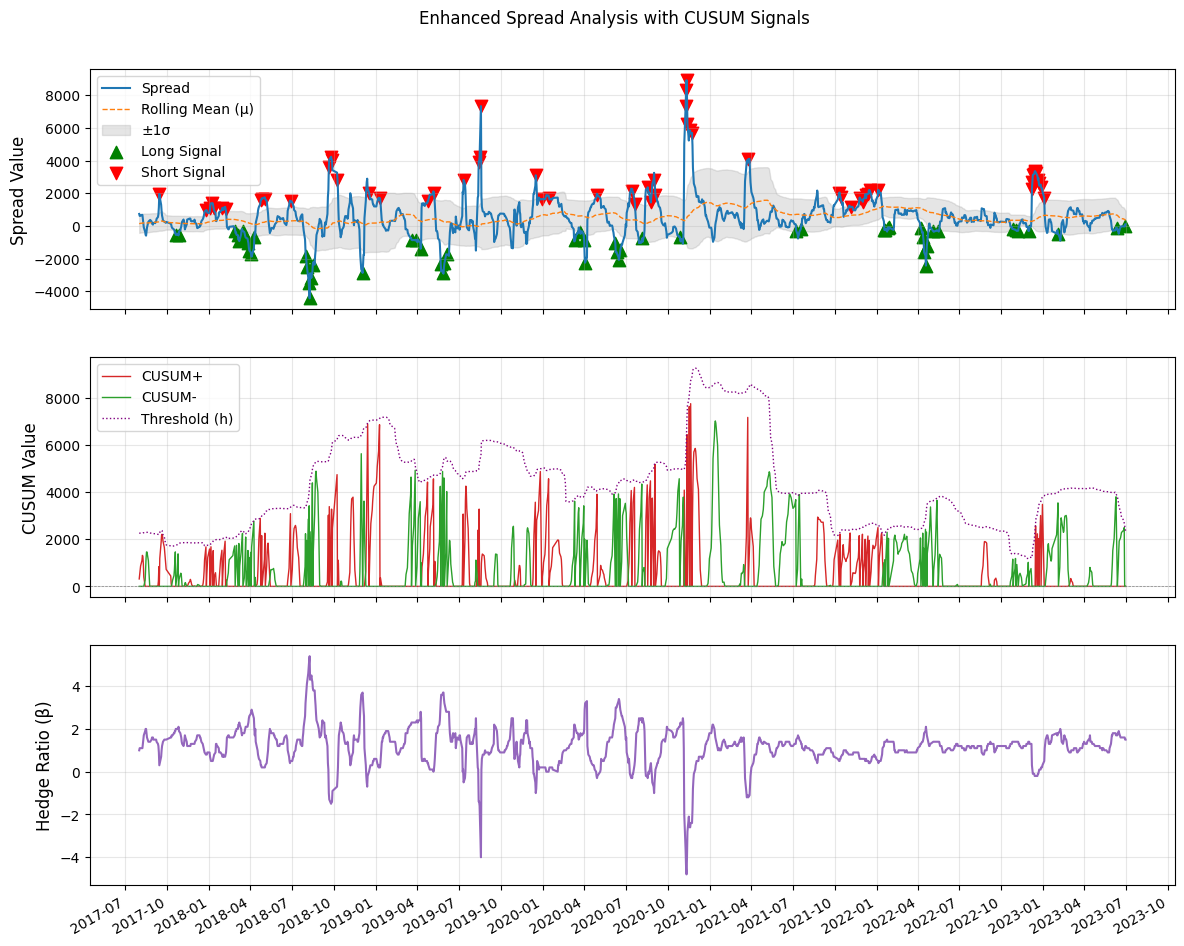

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

def enhanced_calculate_spread(df0, df1, window=120, cusum_win=120, k_coeff=0.5, h_coeff=4):
    """
    增强版价差计算，包含CUSUM信号生成
    返回包含以下字段的DataFrame:
    date | close | beta | mu | sigma | g_pos | g_neg | signal
    """
    # 计算基础价差
    spread_df = calculate_rolling_spread(df0, df1, window=window)
    
    # 初始化CUSUM相关列
    spread_df['mu'] = np.nan
    spread_df['sigma'] = np.nan
    spread_df['g_pos'] = 0.0
    spread_df['g_neg'] = 0.0
    spread_df['signal'] = 0  # 1: long, -1: short
    
    for i in range(cusum_win, len(spread_df)):
        # 使用前cusum_win个数据计算统计量
        hist = spread_df['close'].iloc[i-cusum_win:i].values
        mu = np.nanmean(hist)
        sigma = np.nanstd(hist, ddof=1)
        
        if np.isnan(sigma) or sigma == 0:
            continue
            
        # 记录参数
        spread_df.loc[spread_df.index[i], 'mu'] = mu
        spread_df.loc[spread_df.index[i], 'sigma'] = sigma
        
        # 计算当前价差修正值
        s_t = spread_df['close'].iloc[i]
        s_t_corrected = s_t - mu
        
        # 更新累积和
        prev_g_pos = spread_df['g_pos'].iloc[i-1]
        prev_g_neg = spread_df['g_neg'].iloc[i-1]
        
        spread_df.loc[spread_df.index[i], 'g_pos'] = max(0, prev_g_pos + s_t_corrected - k_coeff*sigma)
        spread_df.loc[spread_df.index[i], 'g_neg'] = max(0, prev_g_neg - s_t_corrected - k_coeff*sigma)
        
        # 生成信号
        h = h_coeff * sigma
        if spread_df['g_pos'].iloc[i] > h:
            spread_df.loc[spread_df.index[i], 'signal'] = -1  # Short signal
            spread_df.loc[spread_df.index[i], ['g_pos', 'g_neg']] = 0.0
        elif spread_df['g_neg'].iloc[i] > h:
            spread_df.loc[spread_df.index[i], 'signal'] = 1   # Long signal
            spread_df.loc[spread_df.index[i], ['g_pos', 'g_neg']] = 0.0

    return spread_df.dropna()

def plot_enhanced_spread(spread_df, start_date=None, end_date=None):
    """可视化增强版价差及交易信号"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # 过滤时间范围
    if start_date and end_date:
        mask = (spread_df['date'] >= start_date) & (spread_df['date'] <= end_date)
        plot_df = spread_df[mask].copy()
    else:
        plot_df = spread_df.copy()
    
    dates = plot_df['date']
    
    # Plot 1: Price Spread and Mu
    ax1.plot(dates, plot_df['close'], label='Spread', color='#1f77b4', lw=1.5)
    ax1.plot(dates, plot_df['mu'], label='Rolling Mean (μ)', color='#ff7f0e', ls='--', lw=1)
    ax1.fill_between(dates, 
                    plot_df['mu'] - plot_df['sigma'], 
                    plot_df['mu'] + plot_df['sigma'],
                    color='gray', alpha=0.2, label='±1σ')
    
    # 标记交易信号
    long_signals = dates[plot_df['signal'] == 1]
    short_signals = dates[plot_df['signal'] == -1]
    ax1.scatter(long_signals, plot_df.loc[plot_df['signal'] == 1, 'close'], 
               marker='^', color='green', s=80, label='Long Signal')
    ax1.scatter(short_signals, plot_df.loc[plot_df['signal'] == -1, 'close'],
               marker='v', color='red', s=80, label='Short Signal')
    
    ax1.set_ylabel('Spread Value', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: CUSUM Indicators
    ax2.plot(dates, plot_df['g_pos'], label='CUSUM+', color='#d62728', lw=1)
    ax2.plot(dates, plot_df['g_neg'], label='CUSUM-', color='#2ca02c', lw=1)
    ax2.axhline(0, color='gray', lw=0.5, ls='--')
    
    # 动态阈值线
    h_values = plot_df['sigma'] * 4  # 假设h_coeff=4
    ax2.plot(dates, h_values, color='purple', ls=':', lw=1, label='Threshold (h)')
    
    ax2.set_ylabel('CUSUM Value', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Beta Values
    ax3.plot(dates, plot_df['beta'], label='Beta', color='#9467bd', lw=1.5)
    ax3.set_ylabel('Hedge Ratio (β)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # 格式化x轴
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    fig.autofmt_xdate()
    
    plt.suptitle('Enhanced Spread Analysis with CUSUM Signals', y=0.93)
    plt.show()

# 使用示例 --------------------------------------------------
# 加载数据
df_j = pd.read_hdf('/Users/f/Desktop/ricequant/1d_2017to2024_noadjust.h5', key='/J').reset_index()
df_jm = pd.read_hdf('/Users/f/Desktop/ricequant/1d_2017to2024_noadjust.h5', key='/JM').reset_index()

# 计算增强版价差数据
enhanced_spread = enhanced_calculate_spread(df_j, df_jm, 
                                          window=20,
                                          cusum_win=120,
                                          k_coeff=0.5,
                                          h_coeff=4)

# 可视化2023年数据
plot_enhanced_spread(enhanced_spread, 
                    start_date='2017-01-01',
                    end_date='2023-06-30')